In [1]:
# imports
import libdtw as lib
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from copy import copy, deepcopy
import os
from model import *
from IPython.display import clear_output
import pandas as pd

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The first step in the realization of the experiment is to select a meaningful time frame. First we plot the length of all the available batches against the starting date to check for any time trend. 

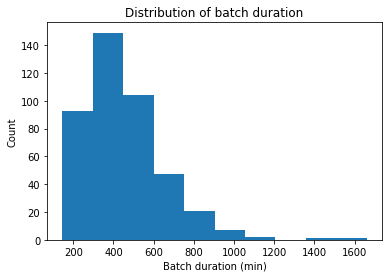

Min duration: 146
Max duration 1661


In [3]:
raw_data = lib.load_data(n_to_keep=1000)
_ = raw_data.pop('reference')
plt.hist([len(v[0]['values']) for k, v in raw_data.items()])
plt.title('Distribution of batch duration')
plt.xlabel('Batch duration (min)')
plt.ylabel('Count')
plt.show()
print("Min duration: %d\nMax duration %d"\
      %(min([len(v[0]['values']) for k, v in raw_data.items()]), max([len(v[0]['values']) for k, v in raw_data.items()])))

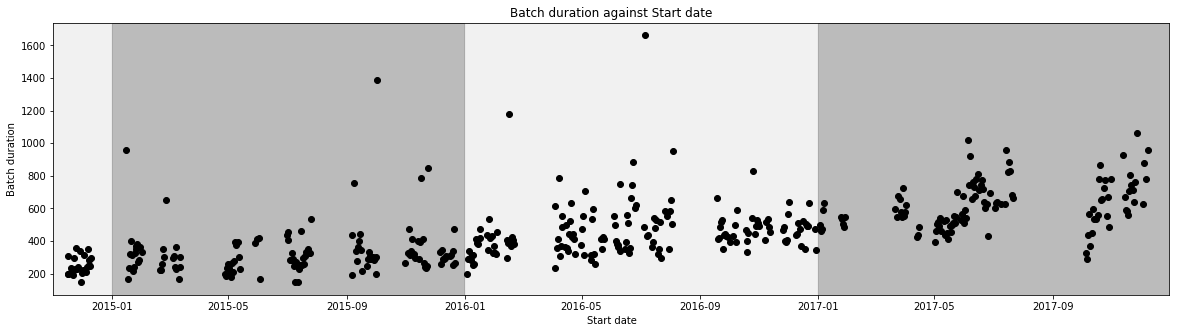

In [4]:
fig = plt.figure(figsize=(20,5))
for k, v in raw_data.items():
    plt.plot_date(date2num(datetime.strptime(v[0]['start'], '%Y-%m-%d %H:%M:%S')), len(v[0]['values']), color = '#000000')
plt.xlabel('Start date')
plt.ylabel('Batch duration')
plt.title('Batch duration against Start date')
plt.xlim((date2num(datetime.strptime('2014-11-01', '%Y-%m-%d')), 
          date2num(datetime.strptime('2017-12-31', '%Y-%m-%d'))))

plt.axvspan(date2num(datetime.strptime('2014-11-01', '%Y-%m-%d')), 
            date2num(datetime.strptime('2014-12-31', '%Y-%m-%d')), 
            color='#787878', alpha=0.1)

plt.axvspan(date2num(datetime.strptime('2015-01-01', '%Y-%m-%d')), 
            date2num(datetime.strptime('2015-12-31', '%Y-%m-%d')), 
            color='#787878', alpha=0.5)

plt.axvspan(date2num(datetime.strptime('2016-01-01', '%Y-%m-%d')), 
            date2num(datetime.strptime('2016-12-31', '%Y-%m-%d')), 
            color='#787878', alpha=0.1)

plt.axvspan(date2num(datetime.strptime('2017-01-01', '%Y-%m-%d')), 
            date2num(datetime.strptime('2017-12-31', '%Y-%m-%d')), 
            color='#787878', alpha=0.5)
plt.show()

The data seems to have a time dependency. This could be useful for the predictive model, but it's unrealistic to use all the data available for the DTW part of the system. Therefore we select only one period, the 2016, and remove the outlier batches: this way DTW will perform better and we will have a wider search space for the step patterns. 

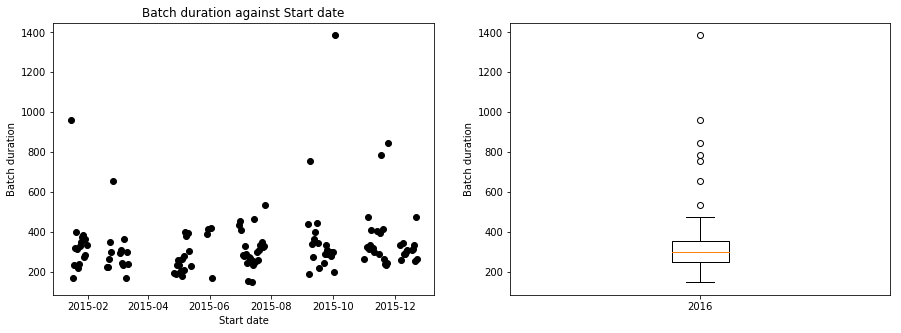

Upper cap value: 476


In [5]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
data_2015 = dict((k, v) for k, v in raw_data.items() if datetime.strptime(v[0]['start'][:4], '%Y') == datetime.strptime('2015', '%Y'))
for k, v in data_2015.items():
    ax0.plot_date(date2num(datetime.strptime(v[0]['start'], '%Y-%m-%d %H:%M:%S')), len(v[0]['values']), color = '#000000')
ax0.set_xlabel('Start date')
ax0.set_ylabel('Batch duration')
ax0.set_title('Batch duration against Start date')

box = ax1.boxplot([len(v[0]['values']) for k, v in data_2015.items()])
ax1.set_ylabel('Batch duration')
plt.setp(ax1, xticklabels=['2016'])
plt.show()

upper_cap = box['caps'][1].get_ydata()[0]
print('Upper cap value: %d'%upper_cap)

Batches with duration above 708 minutes are considered outliers. We remove them from the dataset.

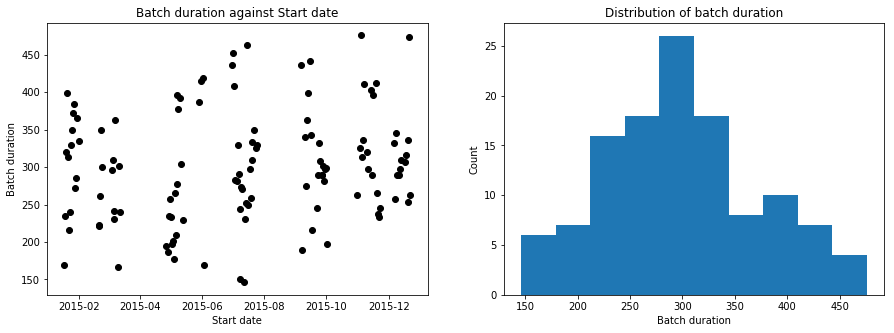

Number of batches: 120


In [6]:
data = dict((k,v) for k,v in data_2015.items() if len(v[0]['values']) <= 476)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
for k, v in data.items():
    ax0.plot_date(date2num(datetime.strptime(v[0]['start'], '%Y-%m-%d %H:%M:%S')), len(v[0]['values']), color = '#000000')
ax0.set_xlabel('Start date')
ax0.set_ylabel('Batch duration')
ax0.set_title('Batch duration against Start date')

ax1.hist([len(v[0]['values']) for k, v in data.items()])
ax1.set_xlabel('Batch duration')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of batch duration')
plt.show()

print('Number of batches: %d'%len(data))

We have 120 batches. We use the first 80 as training set, and the other 40 as test. The IDs are assigned in temporal order, so we can use them as splitting criterion.

In [7]:
train_size = 80
train_data = dict(sorted(list(data.items()))[:train_size])
raw_test_data = dict(sorted(list(data.items()))[train_size:])
print("Train data: %d batches\nTest data: %d batches"%(len(train_data), len(raw_test_data)))

Train data: 80 batches
Test data: 40 batches


We now create the DTW object for the training data, checking the maximum P value allowed for the step pattern. We seelect the batch with the median length as reference one.

In [8]:
if 'reference' in train_data: _=train_data.pop('reference')
train_data = lib.assign_ref(train_data)
D = lib.Dtw(json_obj=train_data)
print('Number of PVs used : %d'%len(D.pv_names))

Number of PVs used : 27


In [9]:
pv_ref = D.pv_names
test_data = dict()
for k, v in raw_test_data.items():
    batch = list(filter(lambda x: x['name'] in pv_ref, v))
    if len(batch) == len(pv_ref):
        test_data[k]=batch
print('Number of test batches after filtering for PVs: %d'%len(test_data))

Number of test batches after filtering for PVs: 40


All of the test batches have the required PVs

Let's check the maximum P value allowed

In [10]:
print('Global P max: %d'%D.get_global_p_max())

Global P max: 1


The maximum allowed value is P = 1. Therefore for the step pattern selection we will consider the step patterns `symmetricP05` and `symmetricP1`, and maybe also `symmetric1` and `symmetric2`.

First step is to optimize the features' weights given this dataset. 

In [11]:
num_queries = D.data['num_queries']
step_pattern = 'symmetric2'
file_path = 'data/optWeights2015.pickle'
n_jobs=-2
try:
    with open(file_path, 'rb') as f:
        D.data['feat_weights'] = pickle.load(f)
    #print('Initial weights:\n', D.data['feat_weights'])
except OSError as ex:
#    pass
#finally:
    D.optimize_weights(step_pattern, n_steps = 20, file_path = file_path, n_jobs=n_jobs)
    with open(file_path, 'wb') as f:
        pickle.dump(D.data['feat_weights'], f, protocol=pickle.HIGHEST_PROTOCOL)

Let's set the variables weights of the original DTW object with the new optimized weights

In [12]:
sorted(list(D.get_weight_variables().items()), key = lambda x: x[1], reverse=True)

[('ba_TCzWpXo', 3.3013334625204744),
 ('ba_TCfg3Yxn', 3.2571817904991933),
 ('ba_TCyNE8Mdv', 1.3643977795430826),
 ('ba_TZHx41ABpBbhN', 1.34604014518613),
 ('ba_FC3BnZ', 1.3376209640933332),
 ('ba_TZWZNzFFdHb', 1.3375262557473873),
 ('ba_FCGUglDXyPKrnk38', 1.2352821032790162),
 ('ba_TDZyHMh1UZ', 1.086377288878238),
 ('ba_TDZV2zDOrmiYP', 1.072935670474598),
 ('ba_PLAu1m2', 0.8495005628163724),
 ('ba_PCPUSq5ah', 0.8372735397704795),
 ('ba_TZv9w2dOu', 0.8197190219635625),
 ('ba_PCSTgdwK3V', 0.7998396885715154),
 ('ba_TC06nRC', 0.7981974384638912),
 ('ba_TZIm086h', 0.7717578388419872),
 ('ba_FCDvhG4', 0.7164987936642214),
 ('ba_PCLAMr1nuoSiAr', 0.7117351676727213),
 ('ba_ErguU', 0.6801588964317755),
 ('ba_PCGd0srEZp', 0.6724972914691789),
 ('ba_TCkwAse0bopy8zp6', 0.6675721809846488),
 ('ba_TIJSj', 0.5572753961648053),
 ('ba_FmYOrhonkk', 0.5251360554076474),
 ('ba_PCG6Z9', 0.4905443889795182),
 ('ba_Fl7pvjqC', 0.48032706264611646),
 ('ba_TrWfpiPrs', 0.46137744250892804),
 ('ba_FQYXdr6Q0', 0

Now it's time to select a step pattern

In [14]:
print('P max: %d'%D.get_global_p_max())
POSSIBLE_STEP_PATTERNS = ['symmetric2', 'symmetricP05'] + ['symmetricP%s'%p for p in np.arange(1, D.get_global_p_max()+1)]
try:
    with open('stepPattern2015.pickle', 'rb') as f:
        D = pickle.load(f)
except: pass

RES = defaultdict(list)
for step_pattern in POSSIBLE_STEP_PATTERNS[::-1]:
    #print(step_pattern)
    for _id in tqdm(D.data['queriesID'], desc=step_pattern, leave=False):
        D.call_dtw(_id, step_pattern=step_pattern, n_jobs=-1)

    RES[step_pattern].append(D.avg_time_distortion(step_pattern))
    RES[step_pattern].append(D.avg_distance(step_pattern))

    # pickle D object
with open('stepPattern2015.pickle', 'wb') as f:
    pickle.dump(D, f, protocol=pickle.HIGHEST_PROTOCOL)

TD = [x[0] for x in RES.values()]
RANGE_TD = min(TD), max(TD)

DIST = [x[1] for x in RES.values()]

RANGE_DIST = min(DIST), max(DIST)

RES_SCALED = defaultdict(list)
for step_pattern in POSSIBLE_STEP_PATTERNS:
    RES_SCALED[step_pattern] = [(RES[step_pattern][0] - RANGE_TD[0])/(RANGE_TD[1]-RANGE_TD[0])]
    RES_SCALED[step_pattern].append((RES[step_pattern][1] - RANGE_DIST[0])/(RANGE_DIST[1]-RANGE_DIST[0]))

DISTORTIONS = [RES_SCALED[step_pattern][0] for step_pattern in POSSIBLE_STEP_PATTERNS]
DISTANCES = [RES_SCALED[step_pattern][1] for step_pattern in POSSIBLE_STEP_PATTERNS]
SCORE = [np.sqrt(x**2 + y**2) for x, y in zip(DISTANCES, DISTORTIONS)]

#print(TD)
#print(DIST)

for step_pattern in POSSIBLE_STEP_PATTERNS:
    score = np.sqrt(RES_SCALED[step_pattern][0]**2 + RES_SCALED[step_pattern][1]**2)
    print('%s Score: %0.5f\tTime Dist: %0.5f/%0.5f\t DTW Dist: %0.5f/%0.5f'%(step_pattern, score, RES[step_pattern][0], 
                                                                             RES_SCALED[step_pattern][0], RES[step_pattern][1], 
                                                                             RES_SCALED[step_pattern][1]))


symmetricP1:   0%|          | 0/79 [00:00<?, ?it/s]
                                                   
symmetricP05:   0%|          | 0/79 [00:00<?, ?it/s]
                                                    
symmetric2:   0%|          | 0/79 [00:00<?, ?it/s]
                                                  

P max: 1
symmetric2 Score: 1.00000	Time Dist: 83.37975/1.00000	 DTW Dist: 510.57306/0.00000
symmetricP05 Score: 0.68939	Time Dist: 66.67089/0.00000	 DTW Dist: 510.72796/0.68939
symmetricP1 Score: 1.00000	Time Dist: 66.67089/0.00000	 DTW Dist: 510.79776/1.00000


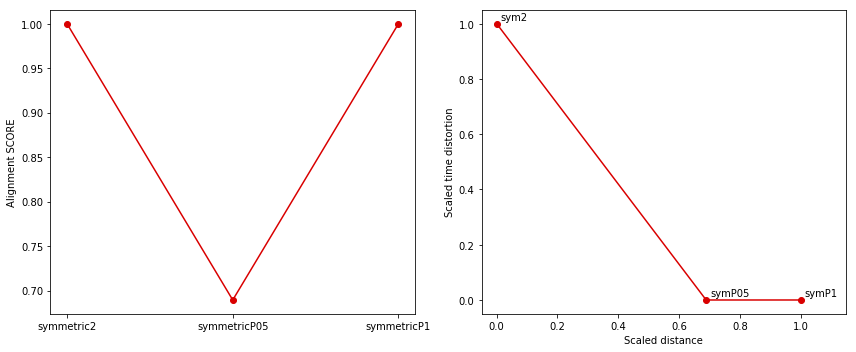

In [15]:
X = np.arange(1, len(SCORE)+1)

FIG = plt.figure(figsize=(12, 5))
FIG.add_subplot(1, 2, 1)

plt.plot(X, SCORE, '-o', color = '#d90000')
plt.xticks(X, POSSIBLE_STEP_PATTERNS, rotation=0)
plt.ylabel("Alignment SCORE")


FIG.add_subplot(1, 2, 2)
plt.plot(DISTANCES, DISTORTIONS, '-o', color = '#d90000')
plt.xlabel("Scaled distance")
plt.ylabel("Scaled time distortion")

for i in range(len(POSSIBLE_STEP_PATTERNS)):
    plt.annotate(POSSIBLE_STEP_PATTERNS[i][:3]+POSSIBLE_STEP_PATTERNS[i].split('c')[1], xy=(DISTANCES[i], DISTORTIONS[i]), xytext=(4, 4), textcoords='offset pixels')
plt.xlim((-0.05, 1.15))
plt.tight_layout()
plt.show()

In [16]:
step_pattern = 'symmetricP05'

In [18]:
try:
    with open('open_ended2015.pickle', 'rb') as f:
        D = pickle.load(f)
except:
    for _id in tqdm(D.data['queriesID'], desc='Open-ended DTW - Train Set', leave=False):
        D.call_dtw(_id, step_pattern=step_pattern, n_jobs=1, open_ended=True, all_sub_seq=True)

In [19]:
with open('open_ended2015.pickle', 'wb') as f:
    pickle.dump(D, f, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
def predict_single_batch(batch, D_train):
    test_batch_id = list(batch.keys())[0]
    if '%s.csv'%test_batch_id in os.listdir('cv_online2015/'): return
    
    D = deepcopy(D_train)
    D.add_query(batch)
    clear_output()
    D.call_dtw(test_batch_id, step_pattern=step_pattern, n_jobs=1, open_ended=True, all_sub_seq=True)
    
    estimator = Estimator(dtw_obj=D)
    for (i, j, d) in tqdm(D.data_open_ended['warp_dist'][test_batch_id], desc='Predicting Batch %s'%test_batch_id):

        data_x, data_y = deepcopy(generate_dataset_xy(i, j, test_batch_id, D, data))

        train_id = data_x.loc[data_x.index != test_batch_id, :].index
        test_id = data_x.loc[data_x.index == test_batch_id, :].index

        train_loc = list()
        for _id in train_id.unique():
            locs = data_x.index.get_loc(_id)
            if type(locs) == slice:
                start, stop = locs.start, locs.stop
                train_loc.extend([[loc] for loc in np.arange(start, stop)])
            elif type(locs) == int or type(locs) == np.int64:
                train_loc.append([locs])
            else: print('\n', locs, type(locs))

        if type(data_x.index.get_loc(test_batch_id)) == slice:
            locs = data_x.index.get_loc(test_batch_id)
            start, stop = locs.start, locs.stop
            test_loc = [[loc] for loc in np.arange(start, stop)]
        elif type(data_x.index.get_loc(test_batch_id)) == int or type(data_x.index.get_loc(test_batch_id)) == np.int64:
            test_loc = [data_x.index.get_loc(test_batch_id)]
        else: print('ERROR 2')

        train_id, test_id, train_loc, test_loc = train_id.unique(), test_id.unique(), train_loc, test_loc
        if len(train_id) < 2:
            continue

        x_train = data_x.loc[train_id, :]

        y_train = np.array(np.concatenate([data_y[idx] for idx in train_loc], axis=0), dtype = [('status', bool), ('time_remaining', 'f8')])

        x_test = data_x.loc[test_id, :]
        y_test_raw = [data_y[idx] for idx in test_loc]

        y_test = np.concatenate(y_test_raw, axis=0) if len(y_test_raw)>1 else y_test_raw
        y_test = np.array(y_test, dtype = [('status', bool), ('time_remaining', 'f8')])

        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)
        with open('cv_online2015/%s.csv'%test_id.values[0], 'a+') as f:
            for (_id, row), y_p in zip(x_test.iterrows(), y_pred):
                true_len = len(D.data['queries'][test_id.values[0]][0]['values'])
                f.write('%s, %d, %d, %0.1f, %0.1f\n'%(test_id.values[0], row['length'], true_len, y_p, true_len - (row['length'] + y_p)))
        

In [21]:
for k, v in test_data.items():
    predict_single_batch({k: v}, D)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  # Remove the CWD from sys.path while we load stuff.


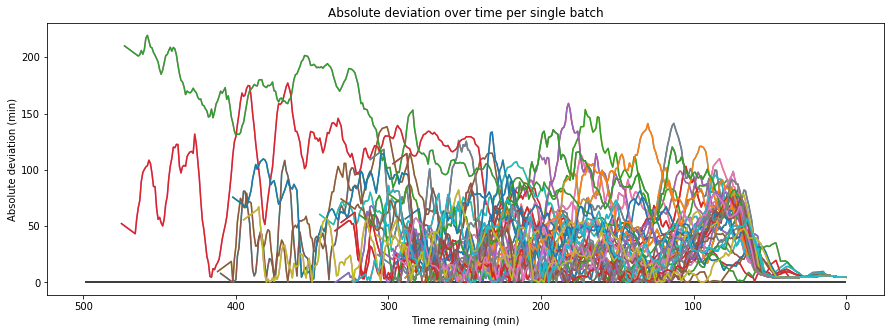

In [22]:
ag = 10
fig = plt.figure(figsize=(15,5))
tot_df = pd.DataFrame()
for fn in os.listdir('cv_online2015/'):
    df = pd.read_csv('cv_online2015/%s'%fn, header=None)
    df.drop_duplicates(inplace=True)
    df['mov_pred'] = df[3].rolling(ag).mean().fillna(method='bfill') + df[1]
    df['err'] = abs(df[2] - df['mov_pred'])
    df['remaining'] = df.loc[:,2] - df.loc[:,1]
    tot_df = pd.concat([tot_df, df], axis = 0)
    plt.plot(df['remaining'], df['err'])
plt.hlines(0, xmin = 0, xmax = plt.xlim()[1])
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('Time remaining (min)')
plt.ylabel('Absolute deviation (min)')
plt.title('Absolute deviation over time per single batch')
plt.show()

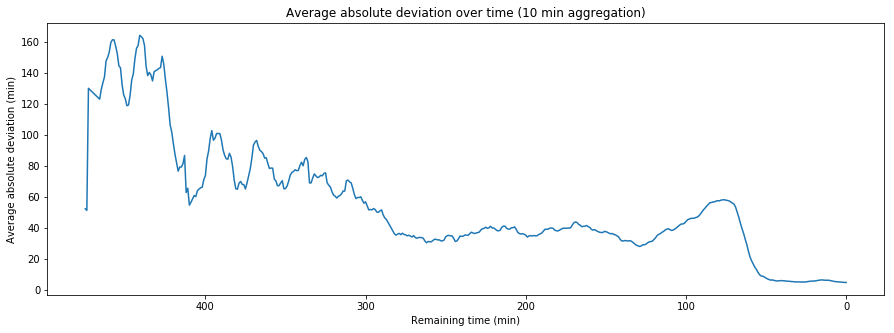

In [23]:
aggr = tot_df.groupby(by=['remaining']).aggregate({'err': 'mean'})
plt.figure(figsize=(15,5))
plt.plot(aggr)
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('Remaining time (min)')
plt.ylabel('Average absolute deviation (min)')
plt.title('Average absolute deviation over time (%d min aggregation)'%ag)
plt.show()

## Random guessing

In [24]:
def predict_average(batch, D_train):
    test_batch_id = list(batch.keys())[0]
    D = deepcopy(D_train)
    D.add_query(batch)

    D.call_dtw(test_batch_id, step_pattern=step_pattern, n_jobs=1, open_ended=True, all_sub_seq=True)

    df = pd.read_csv('cv_online2015/%s.csv'%test_batch_id, header=None, index_col=None)
    for (i, j, d) in tqdm(D.data_open_ended['warp_dist'][test_batch_id], desc='Predicting Batch %s'%test_batch_id, leave=False):
        data_x, data_y = deepcopy(generate_dataset_xy(i, j, test_batch_id, D, data))

        train_id = data_x.loc[data_x.index != test_batch_id, :].index
        test_id = data_x.loc[data_x.index == test_batch_id, :].index
        
        preds = list()

        for _id in train_id:
            true_len = len(D.data['queries'][_id][0]['values'])
            map_len = np.mean(data_x.loc[data_x.index == _id, 'length'].values)
            preds.append(true_len - map_len)
        df.loc[df[1] == i, 5] = np.mean(preds) if preds else np.nan
    
    df.to_csv('cv_online2015/%s_avg.csv'%test_batch_id, header=False, index=False)
    return

In [25]:
for k, v in test_data.items():
    df = predict_average({k: v}, D)



Predicting Batch 5190:   0%|          | 0/245 [00:00<?, ?it/s]

Predicting Batch 5190:   0%|          | 1/245 [00:00<00:28,  8.56it/s]

Predicting Batch 5190:   1%|          | 2/245 [00:00<00:39,  6.20it/s]

Predicting Batch 5190:   1%|          | 3/245 [00:00<00:44,  5.42it/s]

Predicting Batch 5190:   2%|▏         | 4/245 [00:00<00:49,  4.83it/s]

Predicting Batch 5190:   2%|▏         | 5/245 [00:01<00:51,  4.63it/s]

Predicting Batch 5190:   2%|▏         | 6/245 [00:01<00:54,  4.43it/s]

Predicting Batch 5190:   3%|▎         | 7/245 [00:01<00:55,  4.32it/s]

Predicting Batch 5190:   3%|▎         | 8/245 [00:01<00:55,  4.25it/s]

Predicting Batch 5190:   4%|▎         | 9/245 [00:02<00:56,  4.20it/s]

Predicting Batch 5190:   4%|▍         | 10/245 [00:02<00:57,  4.12it/s]

Predicting Batch 5190:   4%|▍         | 11/245 [00:02<00:56,  4.12it/s]

Predicting Batch 5190:   5%|▍         | 12/245 [00:02<00:56,  4.16it/s]

Predicting Batch 5190:   5%|▌         | 13/245 [00:03<00:56,  4.07i

Predicting Batch 5190:  88%|████████▊ | 215/245 [00:39<00:02, 11.44it/s]

Predicting Batch 5190:  89%|████████▊ | 217/245 [00:39<00:02, 11.38it/s]

Predicting Batch 5190:  89%|████████▉ | 219/245 [00:39<00:02, 11.22it/s]

Predicting Batch 5190:  90%|█████████ | 221/245 [00:40<00:02, 11.20it/s]

Predicting Batch 5190:  91%|█████████ | 223/245 [00:40<00:02, 10.96it/s]

Predicting Batch 5190:  92%|█████████▏| 225/245 [00:40<00:01, 10.79it/s]

Predicting Batch 5190:  93%|█████████▎| 227/245 [00:40<00:01, 10.49it/s]

Predicting Batch 5190:  93%|█████████▎| 229/245 [00:40<00:01, 10.36it/s]

Predicting Batch 5190:  94%|█████████▍| 231/245 [00:41<00:01, 10.13it/s]

Predicting Batch 5190:  95%|█████████▌| 233/245 [00:41<00:01, 10.08it/s]

Predicting Batch 5190:  96%|█████████▌| 235/245 [00:41<00:01,  9.10it/s]

Predicting Batch 5190:  96%|█████████▋| 236/245 [00:41<00:01,  8.82it/s]

Predicting Batch 5190:  97%|█████████▋| 237/245 [00:41<00:00,  8.64it/s]

Predicting Batch 5190:  97%|█████████▋

Predicting Batch 5191:  64%|██████▎   | 184/289 [00:36<00:16,  6.41it/s]

Predicting Batch 5191:  64%|██████▍   | 185/289 [00:36<00:15,  6.54it/s]

Predicting Batch 5191:  64%|██████▍   | 186/289 [00:36<00:15,  6.64it/s]

Predicting Batch 5191:  65%|██████▍   | 187/289 [00:37<00:16,  6.25it/s]

Predicting Batch 5191:  65%|██████▌   | 188/289 [00:37<00:15,  6.36it/s]

Predicting Batch 5191:  65%|██████▌   | 189/289 [00:37<00:15,  6.31it/s]

Predicting Batch 5191:  66%|██████▌   | 190/289 [00:37<00:15,  6.32it/s]

Predicting Batch 5191:  66%|██████▌   | 191/289 [00:37<00:14,  6.54it/s]

Predicting Batch 5191:  66%|██████▋   | 192/289 [00:37<00:14,  6.68it/s]

Predicting Batch 5191:  67%|██████▋   | 193/289 [00:38<00:14,  6.80it/s]

Predicting Batch 5191:  67%|██████▋   | 194/289 [00:38<00:14,  6.73it/s]

Predicting Batch 5191:  67%|██████▋   | 195/289 [00:38<00:13,  7.05it/s]

Predicting Batch 5191:  68%|██████▊   | 196/289 [00:38<00:13,  7.08it/s]

Predicting Batch 5191:  68%|██████▊   

Predicting Batch 5192:  37%|███▋      | 123/332 [00:26<00:37,  5.53it/s]

Predicting Batch 5192:  37%|███▋      | 124/332 [00:26<00:38,  5.41it/s]

Predicting Batch 5192:  38%|███▊      | 125/332 [00:26<00:38,  5.37it/s]

Predicting Batch 5192:  38%|███▊      | 126/332 [00:26<00:37,  5.43it/s]

Predicting Batch 5192:  38%|███▊      | 127/332 [00:26<00:37,  5.49it/s]

Predicting Batch 5192:  39%|███▊      | 128/332 [00:27<00:37,  5.51it/s]

Predicting Batch 5192:  39%|███▉      | 129/332 [00:27<00:35,  5.71it/s]

Predicting Batch 5192:  39%|███▉      | 130/332 [00:27<00:34,  5.82it/s]

Predicting Batch 5192:  39%|███▉      | 131/332 [00:27<00:35,  5.67it/s]

Predicting Batch 5192:  40%|███▉      | 132/332 [00:27<00:34,  5.77it/s]

Predicting Batch 5192:  40%|████      | 133/332 [00:27<00:34,  5.85it/s]

Predicting Batch 5192:  40%|████      | 134/332 [00:28<00:34,  5.70it/s]

Predicting Batch 5192:  41%|████      | 135/332 [00:28<00:34,  5.69it/s]

Predicting Batch 5192:  41%|████      

Predicting Batch 5193:   5%|▌         | 16/308 [00:03<01:08,  4.24it/s]

Predicting Batch 5193:   6%|▌         | 17/308 [00:03<01:09,  4.17it/s]

Predicting Batch 5193:   6%|▌         | 18/308 [00:04<01:08,  4.23it/s]

Predicting Batch 5193:   6%|▌         | 19/308 [00:04<01:07,  4.27it/s]

Predicting Batch 5193:   6%|▋         | 20/308 [00:04<01:06,  4.32it/s]

Predicting Batch 5193:   7%|▋         | 21/308 [00:04<01:06,  4.34it/s]

Predicting Batch 5193:   7%|▋         | 22/308 [00:05<01:06,  4.29it/s]

Predicting Batch 5193:   7%|▋         | 23/308 [00:05<01:05,  4.38it/s]

Predicting Batch 5193:   8%|▊         | 24/308 [00:05<01:05,  4.33it/s]

Predicting Batch 5193:   8%|▊         | 25/308 [00:05<01:04,  4.36it/s]

Predicting Batch 5193:   8%|▊         | 26/308 [00:05<01:05,  4.28it/s]

Predicting Batch 5193:   9%|▉         | 27/308 [00:06<01:05,  4.30it/s]

Predicting Batch 5193:   9%|▉         | 28/308 [00:06<01:03,  4.39it/s]

Predicting Batch 5193:   9%|▉         | 29/308 [00:

Predicting Batch 5193:  72%|███████▏  | 221/308 [00:41<00:14,  5.81it/s]

Predicting Batch 5193:  72%|███████▏  | 222/308 [00:41<00:13,  6.48it/s]

Predicting Batch 5193:  72%|███████▏  | 223/308 [00:41<00:12,  7.02it/s]

Predicting Batch 5193:  73%|███████▎  | 224/308 [00:42<00:11,  7.19it/s]

Predicting Batch 5193:  73%|███████▎  | 225/308 [00:42<00:11,  7.28it/s]

Predicting Batch 5193:  73%|███████▎  | 226/308 [00:42<00:11,  7.39it/s]

Predicting Batch 5193:  74%|███████▎  | 227/308 [00:42<00:10,  7.88it/s]

Predicting Batch 5193:  74%|███████▍  | 228/308 [00:42<00:09,  8.26it/s]

Predicting Batch 5193:  74%|███████▍  | 229/308 [00:42<00:09,  8.65it/s]

Predicting Batch 5193:  75%|███████▍  | 230/308 [00:42<00:08,  8.95it/s]

Predicting Batch 5193:  75%|███████▌  | 231/308 [00:42<00:08,  9.11it/s]

Predicting Batch 5193:  75%|███████▌  | 232/308 [00:43<00:08,  9.20it/s]

Predicting Batch 5193:  76%|███████▌  | 233/308 [00:43<00:08,  8.73it/s]

Predicting Batch 5193:  76%|███████▌  

KeyError: 'the label [length] is not in the [columns]'

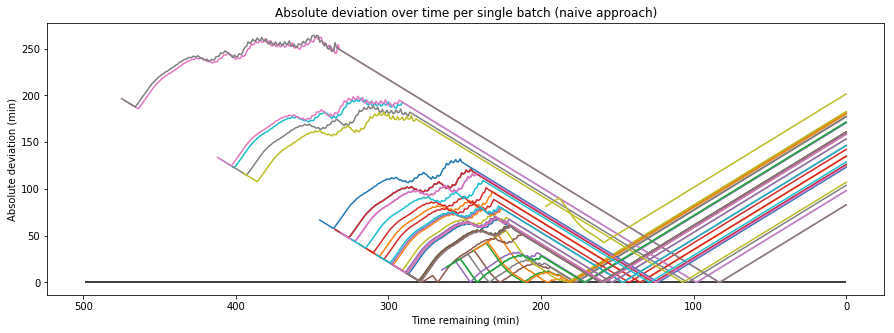

In [26]:
ag = 10
fig = plt.figure(figsize=(15,5))
tot_df1 = pd.DataFrame()
for fn in [name for name in os.listdir('cv_online2015/') if name.split('.')[0].endswith('avg')]:
    df = pd.read_csv('cv_online2015/%s'%fn, header=None)
    df.drop_duplicates(inplace=True)
    df['mov_pred'] = df[5].rolling(ag).mean().fillna(method='bfill').fillna(method='ffill') + df[1]
    df['err'] = abs(df[2] - df['mov_pred'])
    df['remaining'] = df.loc[:,2] - df.loc[:,1]
    tot_df1 = pd.concat([tot_df1, df], axis = 0)
    plt.plot(df['remaining'], df['err'])
plt.hlines(0, xmin = 0, xmax = plt.xlim()[1])
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('Time remaining (min)')
plt.ylabel('Absolute deviation (min)')
plt.title('Absolute deviation over time per single batch (naive approach)')
plt.show()

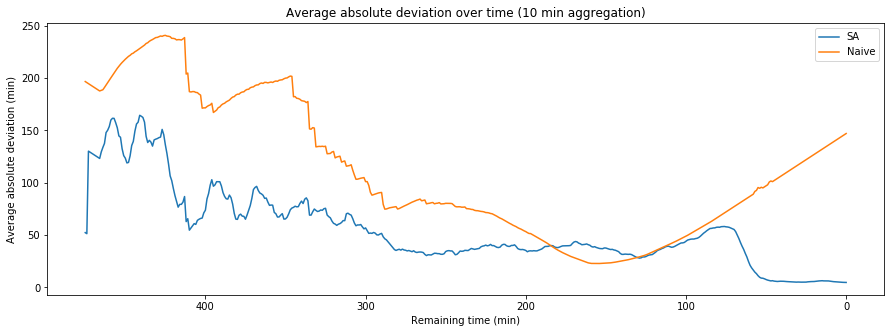

In [27]:
aggr = tot_df.groupby(by=['remaining']).aggregate({'err': 'mean'})
plt.figure(figsize=(15,5))
plt.plot(aggr, label = 'SA')
ax = plt.gca()
ax.invert_xaxis()

aggr = tot_df1.groupby(by=['remaining']).aggregate({'err': 'mean'})
plt.plot(aggr, label = 'Naive')
#ax = plt.gca()
#ax.invert_xaxis()
plt.xlabel('Remaining time (min)')
plt.ylabel('Average absolute deviation (min)')
plt.title('Average absolute deviation over time (%d min aggregation)'%ag)
plt.legend()
plt.show()

## Average Prediction

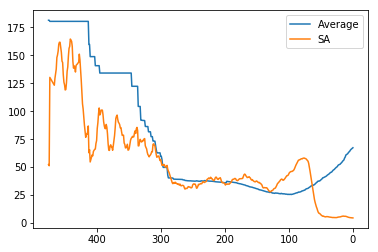

In [64]:
errs = defaultdict(list)
dftot = pd.DataFrame()
for fn in os.listdir('cv_online2015/'):
    if not fn.split('.')[0].endswith('avg'):
        fp = 'cv_online2015/%s'%fn
        df = pd.read_csv(fp, header = None, index_col=None)
        batch_id = str(df[0][0])
        for _id, row in df.iterrows():
            t = row[1]
            lengths = [len(v[0]['values']) for k, v in train_data.items() if k != 'reference' and len(v[0]['values']) > t]
            pred = np.mean(lengths) if lengths else np.nan
            err = row[2] - pred

            errs[batch_id].append((row[2] -t, err))
            dftot = pd.concat([dftot, pd.DataFrame({'r': row[2] -t, 'e': abs(err)}, index=[0])], ignore_index=True, axis=0)
            
    

aggr = tot_df.groupby(by=['remaining']).aggregate({'err': 'mean'})
aggreg = dftot.groupby(by=['r']).aggregate({'e': 'mean'})
plt.plot(aggreg, label = 'Average')
plt.plot(aggr, label = 'SA')
plt.legend()
ax = plt.gca()
ax.invert_xaxis()
plt.show()